# Example 10 - Plug flow reactor yield with mixed type inputs

In this example, we will demonstrate how we handle mixed type inputs in NEXTorch. We use the same problem as in [Example 5](05_PFR_yield.ipynb). The examples we presented before all have continuous parameters. However, depending on the problem, the parameters can also be catergocial or ordinal and the resulting design space can be discrete or mixed (continuous-discrete). If the number of discrete combinations is low, one possible solution is to enumerate the values, and then optimize the continuous parameters for each. On the other hand, if the number of discretization along one parameter is high, we could treat this parameter as continuous. 

In NEXTorch, we use a continuous relaxation approach where the acqucision function is optimized in the relaxed space and rounded to the available values. For ordinal parameters, these values are the order discrete values. For catergocial parameters, we encode the categories with integers from 0 to $n_{category} - 1$ and then perform continuous relaxation in the encoding space. This approach usually works well for problems with high discrete combinations. 

Here we demonstrate the approach by optimizing the plug flow reactor (PFR) yield. The objective function is modified to take ordinal and categorical parameters. The three paremeters are defined as: 

| Parameter     | Type | Values |
| :----------------- | :--------------- | :----------------------------------------- |
| T - reaction temperature (°C) | Ordinal | 140-200, with an interval of 5 | 
| pH - reaction pH | Categorical | Low, medium low, medium, medium high, high (or 0, 0.25, 0.5, 0.75, 1.0) | 
| tf - final residence time (min) | Continuous | $10^{-2} - 10^{2} $ |


The other details of this example is summarized in the table below:

| Key Item      | Description |
| :----------------- | :---------------------------- |
| Goal | Maximization |
| Objective function | PFR model |
| Input (X) dimension | 3 |
| Output (Y) dimension | 1 |
| Analytical form available? | Yes |
| Acqucision function | Expected improvement (EI) |
| Initial Sampling | Random sampling or latin hypercube | 

Next, we will go through each step in Bayesian Optimization.


## 1. Import `nextorch` and other packages

In [18]:
import os
import sys
import time
from IPython.display import display

project_path = os.path.abspath(os.path.join(os.getcwd(), '..\..'))
sys.path.insert(0, project_path)

# Set the path for objective function
objective_path = os.path.join(project_path, 'examples', 'PFR')
sys.path.insert(0, objective_path)

import numpy as np
from nextorch import plotting, bo, doe, utils, io

# We use the Parameter class to define each parameter 
# and ParameterSpace to define the entire parameter space
from nextorch.utils import Parameter, ParameterSpace

## 2. Define the objective function and the design space
We import the PFR model, and wrap it in a Python function called `PFR_yield` as the objective function `objective_func`. 

We specify the ranges and types of parameters uisng the `Parameter` class and use the `ParameterSpace` class to define the entire design space.

In [19]:
#%% Define the objective function
from fructose_pfr_model_function import Reactor

def PFR_yield(X_real):
    """PFR model

    Parameters
    ----------
    X_real : numpy matrix
        reactor parameters: 
        T, pH and tf in real scales

    Returns
    -------
    Y_real: numpy matrix
        reactor yield 
    """
    # a mapping from categorical levels to numerical values
    pH_values = {'low': 0.0,
                'medium low': 0.25,
                'medium': 0.5,
                'medium high': 0.75,
                'high': 1.0}
    
    if len(X_real.shape) < 2:
        X_real = np.expand_dims(X_real, axis=1) #If 1D, make it 2D array
        
    Y_real = []
    for i, xi in enumerate(X_real):
        Conditions = {'T_degC (C)': xi[0], 'pH': pH_values[xi[1]], 'tf (min)' : 10**xi[2]}
        yi, _ = Reactor(**Conditions) # only keep the first output       
        Y_real.append(yi)
            
    Y_real = np.array(Y_real)
    # Put y in a column
    Y_real = np.expand_dims(Y_real, axis=1)
        
    return Y_real # yield

# Objective function
objective_func = PFR_yield


#%% Define the design space
# Three input temperature C, pH, log10(residence time)
X_name_list = ['T', 'pH', r'$\rm log_{10}(tf_{min})$']
X_units = [r'$\rm ^{o}C $', '', '']

# Add the units
X_name_with_unit = []
for i, var in enumerate(X_name_list):
    if not X_units[i]  == '':
        var = var + ' ('+ X_units[i] + ')'
    X_name_with_unit.append(var)
    
# One output
Y_name_with_unit = 'Yield %'

# combine X and Y names
var_names = X_name_with_unit + [Y_name_with_unit]

# Set the type and range for each parameter
parameter_1 = Parameter(x_type = 'ordinal', x_range=[140, 200], interval = 5)
parameter_2 = Parameter(x_type = 'categorical', values=['low', 'medium low', 'medium', 'medium high', 'high'])
parameter_3 = Parameter(x_type = 'continuous', x_range=[-2, 2])
parameters = [parameter_1, parameter_2, parameter_3]

# Initialize a ParameterSpace
parameter_space = ParameterSpace(parameters)

# The ranges can be extracted from ParameterSpace class
X_ranges = parameter_space.X_ranges

# Set the reponse range
Y_plot_range = [0, 50]

# Get the information of the design space
n_dim = len(X_name_list) # the dimension of inputs
n_objective = 1 # the dimension of outputs

## 3. Define the initial sampling plan
Here we compare two sampling plans with the same number of sampling points:

1. Completely random design with 50 points in total. 
2. Latin hypercube (LHC) design with 10 initial sampling points, and 40 more Bayesian Optimization trials

Given a `parameter_space` object, the function `unit_to_encode_ParameterSpace` converts `X` from the continuous space to the encoded (discrete) space. Next, the reponses in a real scale `Y_real` is computed from the helper function `bo.eval_objective_func_encoding(X_encoded, parameter_space, objective_func)`. 

We can see the encoded sampling points are slight away from the original points since they can only take certain discrete values and we round them to the nearest discrete point.  

C:\Users\yifan\Anaconda3\envs\torch\lib\site-packages\scipy\integrate\_ode.py:1182: UserWarning: dopri5: larger nsteps is needed
  self.messages.get(istate, unexpected_istate_msg)))


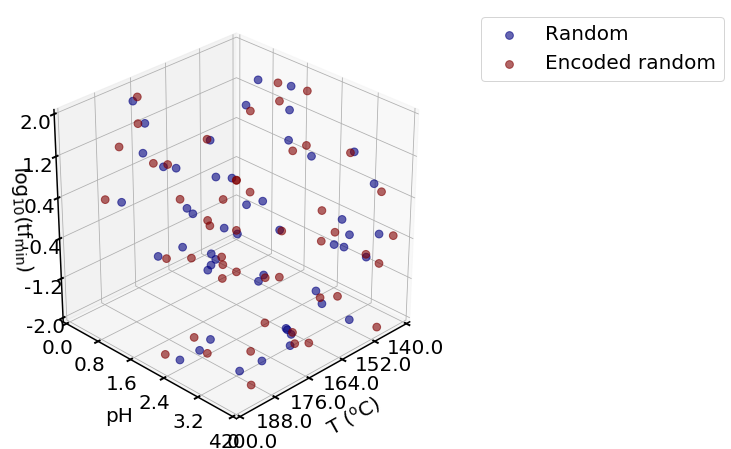

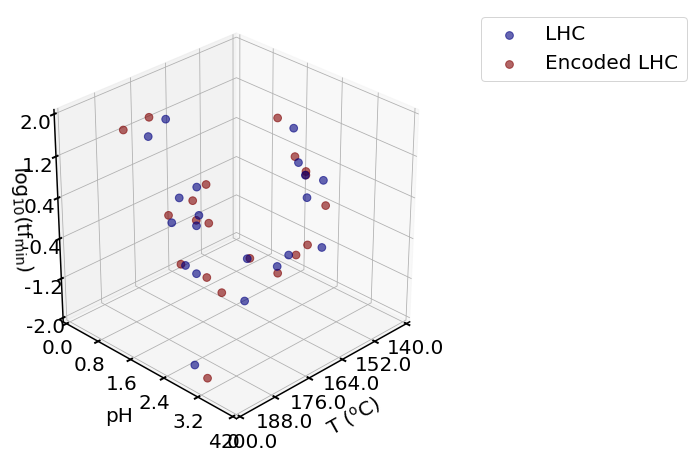

In [20]:
#%% Initial Sampling 
n_total = 50
random_seed = 1

# Completely random design 
X_random_original = doe.randomized_design(n_dim=n_dim, n_points=n_total, seed=random_seed)
# Encode X to the discrete space
X_random = utils.unit_to_encode_ParameterSpace(X_random_original, parameter_space)
# Get the responses
Y_random_real = bo.eval_objective_func_encoding(X_random, parameter_space, objective_func)

# Visualize the original and encoded sampling plans
plotting.sampling_3d([X_random_original, X_random], 
                     X_names = X_name_with_unit,
                     X_ranges = X_ranges,
                     design_names = ['Random', 'Encoded random'])

# Latin hypercube design with 20 initial points
n_init_lhc = 20
X_init_lhc_orginal = doe.latin_hypercube(n_dim=n_dim, n_points=n_init_lhc, seed=random_seed)
# Encode X to the discrete space
X_init_lhc = utils.unit_to_encode_ParameterSpace(X_init_lhc_orginal, parameter_space)
# Get the initial responses
Y_init_lhc = bo.eval_objective_func_encoding(X_init_lhc, parameter_space, objective_func)


# Visualize the original and encoded sampling plans
plotting.sampling_3d([X_init_lhc_orginal, X_init_lhc], 
                     X_names = X_name_with_unit,
                     X_ranges = X_ranges,
                     design_names = ['LHC', 'Encoded LHC'])


## 4. Initialize an `Experiment` object 

Next, we initialize two `Experiment` objects for LHC. We also set the objective function and the goal as maximization. We use `Experiment.define_space()` to input the parameters. The rest steps remain the same. 


In [21]:
#%% Initialize an Experiment object
# Set its name, the files will be saved under the folder with the same name
Exp_lhc = bo.Experiment('PFR_yield_lhc')

# Define the parameter space
Exp_lhc.define_space(parameters)

# Import the initial data
Exp_lhc.input_data(X_init_lhc, Y_init_lhc, unit_flag = True)
# Set the optimization specifications 
# here we set the objective function, minimization by default
Exp_lhc.set_optim_specs(objective_func = objective_func, 
                        maximize =  True)

Iter 10/100: 1.8426282405853271
Iter 20/100: 1.7234007120132446
Iter 30/100: 1.5722049474716187


## 5. Run trials 
We perform 30 more Bayesian Optimization trials for the LHC design using the default acquisition function (Expected Improvement (EI)). Both `X_new` and `X_new_real` are already encoded to the discrete space.

In [22]:
#%% Optimization loop
# Set the number of iterations  
n_trials_lhc = n_total - n_init_lhc
for i in range(n_trials_lhc):
    # Generate the next experiment point
    X_new, X_new_real, acq_func = Exp_lhc.generate_next_point()
    # Get the reponse at this point
    Y_new_real = objective_func(X_new_real) 
    # or 
    # Y_new_real = bo.eval_objective_func_encoding(X_new, parameter_space, objective_func)

    # Retrain the model by input the next point into Exp object
    Exp_lhc.run_trial(X_new, X_new_real, Y_new_real)

Iter 10/100: 0.39252039790153503


## 6. Visualize the final model reponses
We would like to see how sampling points scattered in the 3D space. A 2D slices of the 3D space is visualized below at a fixed x value. 

LHC sampling points


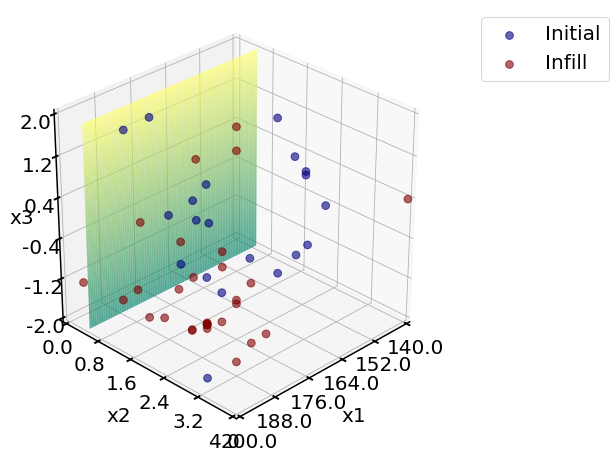

In [23]:
#%% plots 
# Check the sampling points
# Final lhc Sampling
x2_fixed_real = 0.5 # fixed x2 value
x_indices = [0, 2] # 0-indexing, for x1 and x3
print('LHC sampling points')
plotting.sampling_3d_exp(Exp_lhc, 
                         slice_axis = 'y', 
                         slice_value_real = x2_fixed_real)    

By fixing the value of pH (`x2`), we can plot the 2D reponse surfaces by varying T (`x1`) and tf (`x3`). It takes a long time to get the reponses from the objective function. 

LHC model heatmap: 


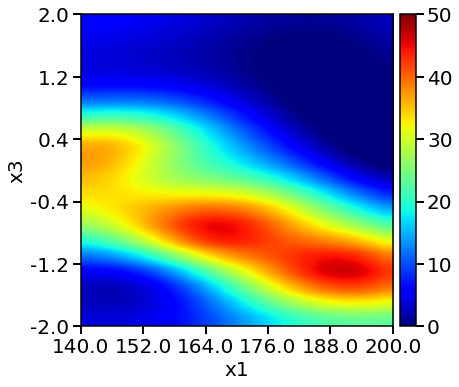

Evaluation of LHC GP model 400 times takes 0.00 min



In [24]:
# Reponse heatmaps
# Set X_test mesh size
mesh_size = 20
n_test = mesh_size**2

# LHC heatmap 
print('LHC model heatmap: ')
start_time = time.time()
plotting.response_heatmap_exp(Exp_lhc, 
                              Y_real_range = Y_plot_range, 
                              x_indices = x_indices, 
                              fixed_values_real = x2_fixed_real,
                              mesh_size = mesh_size)
end_time = time.time()
print('Evaluation of LHC GP model {} times takes {:.2f} min\n'.format(n_test, (end_time-start_time)/60))

The rates can also be plotted as response surfaces in 3D. 
Both the heatmap and response surface are not as accurated compared to the ones in [Example 5](05_PFR_yield.ipynb) but the general trend remains.

Full fatorial model surface: 


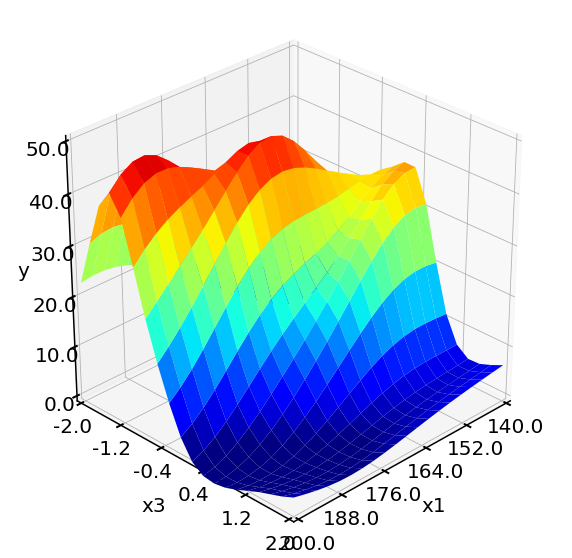

Evaluation of LHC GP model 400 times takes 0.00 min



In [25]:
# Suface plots   
# LHC surface plot
print('Full fatorial model surface: ')
start_time = time.time()
plotting.response_surface_exp(Exp_lhc, 
                              Y_real_range = Y_plot_range,
                              x_indices = x_indices, 
                              fixed_values_real = x2_fixed_real,
                              mesh_size = mesh_size)
end_time = time.time()
print('Evaluation of LHC GP model {} times takes {:.2f} min\n'.format(n_test, (end_time-start_time)/60))


## 7. Export the optimum

Compare two plans in terms optimum discovered in each trial.

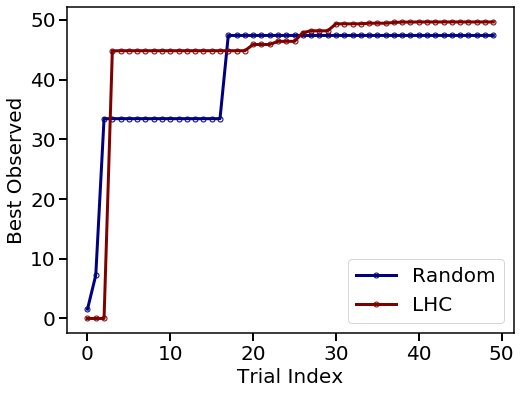

In [26]:
plotting.opt_per_trial([Y_random_real, Exp_lhc.Y_real], 
                       design_names = ['Random', 'LHC'])

Obtain the optimum from the LHC method. The value is closed to the optimum value of 50.10% in [Example 5](05_PFR_yield.ipynb).

In [27]:
# lhc optimum
y_opt_lhc, X_opt_lhc, index_opt_lhc = Exp_lhc.get_optim()
data_opt_lhc = io.np_to_dataframe([X_opt_lhc, y_opt_lhc], var_names)

print('From LHC + Bayesian Optimization, ')
display(data_opt_lhc)

From LHC + Bayesian Optimization, 


,T ($\rm ^{o}C $),pH,$\rm log_{10}(tf_{min})$,Yield %
0,195,medium high,-0.947631,49.6353


We can check out the entire data set and see what values Temperature and pH take. The values are stricly defined by the ordinal discrete numbers or categories.

In [28]:
print('The entire data set, encoded X in a real scale ')
data_all_opt = io.np_to_dataframe([Exp_lhc.X_real, Exp_lhc.Y_real], var_names)
display(data_all_opt.head(10))

print('The entire data set, encoded X in a unit scale ')
data_all_opt = io.np_to_dataframe([Exp_lhc.X, Exp_lhc.Y_real], var_names)
display(data_all_opt.head(10))

The entire data set, encoded X in a real scale 


,T ($\rm ^{o}C $),pH,$\rm log_{10}(tf_{min})$,Yield %
0,185,medium low,1.93995,-5.55204e-11
1,185,medium,0.749633,0.000366361
2,195,medium high,1.71482,-4.14405e-11
3,165,medium low,-0.639851,44.7966
4,165,low,-0.888262,44.8212
5,170,high,1.05872,2.6467
6,190,medium high,-0.461535,39.8387
7,175,medium low,-1.19452,39.1461
8,145,medium,0.263103,40.2217
9,180,low,1.20387,-1.59529e-11


The entire data set, encoded X in a unit scale 


,T ($\rm ^{o}C $),pH,$\rm log_{10}(tf_{min})$,Yield %
0,0.750000,0.25,0.984988,-5.552036e-11
1,0.750000,0.50,0.687408,3.663614e-04
2,0.916667,0.75,0.928706,-4.144054e-11
3,0.416667,0.25,0.340037,4.479656e+01
4,0.416667,0.00,0.277934,4.482122e+01
5,0.500000,1.00,0.764681,2.646700e+00
6,0.833333,0.75,0.384616,3.983872e+01
7,0.583333,0.25,0.201369,3.914614e+01
8,0.083333,0.50,0.565776,4.022173e+01
9,0.666667,0.00,0.800968,-1.595289e-11


## References:

1. BoTorch/Ax GitHub issues on mixed-type inputs:
- https://github.com/pytorch/botorch/issues/177
- https://github.com/pytorch/botorch/issues/400
- https://github.com/facebook/Ax/issues/494

2. Desir, P.; Saha, B.; Vlachos, D. G. Energy Environ. Sci. 2019.

3. Swift, T. D.; Bagia, C.; Choudhary, V.; Peklaris, G.; Nikolakis, V.; Vlachos, D. G. ACS Catal. 2014, 4 (1), 259–267

4. The PFR model can be found on GitHub: https://github.com/VlachosGroup/Fructose-HMF-Model